## 1. Import libraries

# References:
1. https://www.kaggle.com/xwxw2929/rossmann-sales-top1

In [2]:
import warnings
import pandas                  as pd
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn                 import linear_model
from sklearn                 import metrics

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [3]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv( '../data/train.csv' )
df_stores_raw = pd.read_csv( '../data/store.csv' )

# Merge dataset
df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

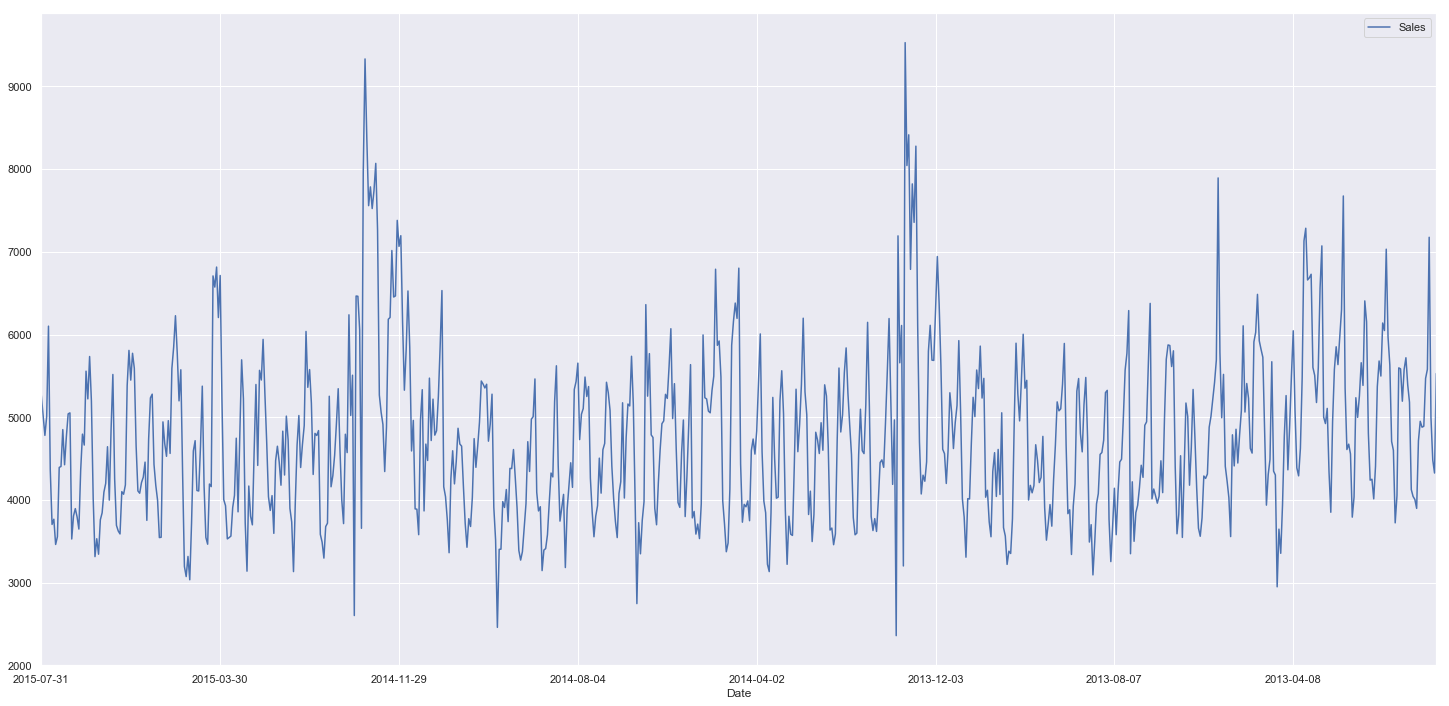

In [11]:
# sales of store 1 full time
strain = df_sales_raw[df_sales_raw['Sales'] > 0]
strain.loc[strain['Store'] == 1, ['Date', 'Sales']].plot(x='Date', y='Sales' )